In [1]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#getting the test and train features
def get_features(datatype):
    if datatype == "train":
        file1 = np.load("train_pos.npz")
        train_pos = file1["arr_0"]

        file2 = np.load("train_neg.npz")
        train_neg = file2["arr_0"]

        return train_pos, train_neg

    elif datatype == "test":
        file1 = np.load("test_pos.npz")
        test_pos = file1["arr_0"]

        file2 = np.load("test_neg.npz")
        test_neg = file2["arr_0"]

        return test_pos, test_neg

In [3]:
def cascade_1stage(features, num_pos, num_neg, FPR_stage_max, T):

    w_pos = np.ones(num_pos)*0.5/num_pos #initializing weights for all the postive images
    w_neg = np.ones(num_neg)*0.5/num_neg #initializing weights for all the negative images
    w_all = np.append(w_pos, w_neg)

    l_pos = np.ones(num_pos) #Setting label of all positive images as 1
    l_neg = np.zeros(num_neg) #Setting label of all negative images as 0
    l_all = np.append(l_pos, l_neg)
    l_all = l_all.astype(np.int)

    all_alpha = [] #Storing all the alpha values of the weak classifiers of a stage
    all_ht = [] #Storing the three values associated with a weak classifier
    all_pred = [] #Storing the predictions made by every weak classifier

    for t in range(T):
        w_all, all_alpha, all_pred, all_ht = best_weak_classifier(features, l_all, w_all, num_pos, all_alpha, all_pred,all_ht)
        imgs_redu_feat = np.dot(np.asarray(all_pred).T, np.asarray(all_alpha)) #Multiplying prediction based on each feature with the trust associated with that feature
        
        og_pos = np.min(imgs_redu_feat[:num_pos]) #Finding the minimum threshold among the given positive images,, this ensures TPR=1
        
        pred_final = np.zeros(imgs_redu_feat.shape)
        pred_final[imgs_redu_feat>=og_pos] = 1 #Thresholding all the images based on the above value.

        fp = np.sum(pred_final[num_pos:])/num_neg #Calculating the number of false positives
        tp = np.sum(pred_final[:num_pos])/num_pos #Calculating the number of true positives
        if fp < FPR_stage_max: #Not adding any more weak classifiers to a stage if the FPR goes below a threshold
            break
            
    false_pos_img = np.sum(pred_final[num_pos:]).astype(int) #Finding out the number of false positives

    new_features = features[:num_pos] #New features consist of all the true postives
    
    for i in range(num_pos,num_pos+num_neg):
        if pred_final[i] == 1: #You also append false positives to the new features
            neg_sample = features[i]
            neg_sample = np.reshape(neg_sample, (1,-1))
            new_features = np.append(new_features,neg_sample, axis = 0)

    number_of_weak_classifiers = t 
    cascade_classifier = [all_ht, new_features, false_pos_img, number_of_weak_classifiers, all_alpha]
    return cascade_classifier


In [4]:
def best_weak_classifier(features, l_all, w_all, num_pos, all_alpha, all_pred, all_ht):
 
    w_all = w_all/np.sum(w_all) #Normalizing the weights

    w_all_un = np.tile(w_all, (np.shape(features)[1],1)) #Duplicating the weight of an image for all its features
    l_all_un = np.tile(l_all, (np.shape(features)[1],1)) #Duplicating the label of an image for all its features
    idx = np.argsort(features, axis = 0) #indexes of all the sorted features 
    
    num_row = np.arange(np.shape(features)[1])
    sorted_l_all = l_all_un[num_row,idx] #All the labels sorted according to the features
    sorted_w_all = w_all_un[num_row,idx] #All the weights sorted according to the features   

    T_pos = np.sum(w_all[:num_pos]) #Sum of all the postive weights
    T_neg = np.sum(w_all[num_pos:]) #Sum of all the negative weights
    
    mask_pos_W = np.multiply(sorted_w_all,sorted_l_all)
    
    S_pos = np.cumsum(mask_pos_W, axis = 0) #Sum of all the postive weights whose feature value is less than threshold
    S_neg = np.cumsum(sorted_w_all, axis = 0) - S_pos #Sum of all the negative weights whose feature value is less than threshold
    
    error1 = S_pos + T_neg - S_neg
    error2 = S_neg + T_pos - S_pos
    error_t= np.stack((error1,error2), axis = 2) #Calculating the error

    idx_min = np.unravel_index(np.argmin(error_t), error_t.shape) #finding the index at which the error_tmatrix is at the lowest value
    min_error_t= error_t[idx_min] 
    
    feat = idx_min[1] #The feature that will best act as the weak classifier
    index = idx[:,feat] #The index of all the images sorted according to the above feature
    
       
    pred = np.zeros(features.shape[0])
    pred_unord = np.zeros(features.shape[0])    


    if idx_min[2] == 1:             #In this case error2 is minimum, thus polarity is positive
        polarity = 1
        pred_unord[:idx_min[0]+1]=1 #Setting all the images before the index idx_min[0]+1 to 1 and the rest to 0
    else:                           #In this case error1 is minimum, thus polarity is negative
        polarity = -1
        pred_unord[idx_min[0]+1:]=1 #Setting all the images afeater the index idx_min[0]+1 to 1 and the rest to 0
    
    pred[index] = pred_unord #Ensuring the predictions have the original order    

    feature = features[:,feat] 
    feature = feature[index]
    
    #Calculating the threshold
    if idx_min[0] == -1:
        thres = feature[-1] + 0.01
    elif idx_min[0] == 0:
        thres = feature[0] - 0.01
    else:
        thres = np.mean(feature[idx_min[0]-1:idx_min[0]+1])

    
    
    #calculating the trust
    beta = min_error_t/(1-min_error_t)
    all_alpha.append(np.log(1/beta))
    
    all_pred.append(np.transpose(pred))    
    all_ht.append([feat, polarity, thres]) #Storing the three values associated with a weak classifier
    w_all = w_all*(beta**(1-np.abs(l_all-pred))) #updating the w_all

    return w_all, all_alpha, all_pred, all_ht


In [5]:
#Training the cascaded classifier
train_pos, train_neg = get_features("train") 
num_pos = train_pos.shape[0] #Storing number of positive samples
num_neg = train_neg.shape[0] #Storing number of negative samples
onum_neg = num_neg

all_feat= np.concatenate((train_pos,train_neg),axis = 0) 

T = 50 # Number of weak classifiers in a stage 
Stages = 10 # Number of stages


FPR_stage_max = 0.5 # The minimum allowed FPR for a stage

FPR_stages = []
classifier = []
features_per_stage = []

for stage in range(Stages):
    a_cascade = cascade_1stage(all_feat, num_pos, num_neg, FPR_stage_max, T)    
    all_feat= a_cascade[1]  #Changing from all images to just the true and false positive images
    num_neg = a_cascade[2]
    fpr = num_neg/onum_neg #Calculating the false positive rate    
    
    FPR_stages.append(fpr) #Saving the FPR for each stage
    classifier.append(a_cascade) #Saving the classifier of each stage
    features_per_stage.append(a_cascade[3]) #Saving the number of features per stage
    
    if num_neg == 0: #Stops adding stages if there are no negative images remaining
        break




C:\Users\adisi\AppData\Local\Temp\ipykernel_14860\3126854157.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l_all = l_all.astype(np.int)


TypeError: 'float' object cannot be interpreted as an integer

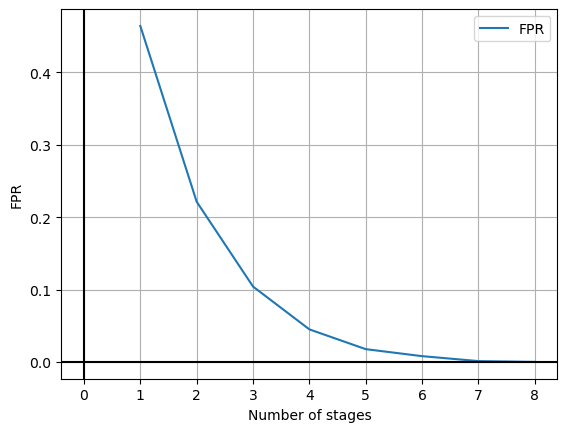

In [6]:
k = np.arange(1,len(classifier)+1,1,dtype=int)
plt.plot(k,np.array(FPR_stages),label = "FPR")

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel('Number of stages')
plt.ylabel('FPR')
plt.legend()
plt.xticks(range(0,len(classifier)+1))
plt.yticks(range(0,1,0.1))

FPR_stages

In [7]:
#Testing the casscaded classifier
test_pos, test_neg = get_features("test") 

fpr_stage = []
fnr_stage = []

stages = len(classifier)
all_feat = np.concatenate((test_pos,test_neg),axis = 0)

num_pos = test_pos.shape[0] #Storing number of positive samples
num_neg = test_neg.shape[0] #Storing number of negative samples
onum_pos = num_pos
onum_neg = num_neg

for stage in range(stages):
    ht_all = classifier[stage][0] 
    alpha_all = classifier[stage][4] #trust in each of the feature tests
    
    feat_no = [sublist[0].astype(int) for sublist in ht_all] #indexes of the features used as weak classifiers
    polarity = np.array([sublist[1] for sublist in ht_all]) #polarity for all the features used as weak classifiers
    thresh = np.array([sublist[2].astype(int) for sublist in ht_all])  #threshold for all the features used as weak classifiers  

    thresh_stage = 0.5*np.sum(alpha_all) 

    imgs_redu_feat = all_feat[:,feat_no] #taking only the features used as classifiers in all the images

    thresh_across_feat = polarity*thresh #thresholds across all the features
    thresh_across_feat = np.tile(thresh_across_feat, (num_pos+num_neg,1)) #Duplicating the values for all images
    nimgs_redu_feat = polarity*imgs_redu_feat 

    pred_all_feat = np.zeros(np.shape(thresh_across_feat))
    pred_all_feat[thresh_across_feat - nimgs_redu_feat >= 0] = 1 #Predicting based on all the reduced features for all the images

    final_pred_val = np.dot(pred_all_feat, alpha_all) 

    final_pred = np.zeros(num_pos+num_neg)
    final_pred[final_pred_val >= thresh_stage] = 1 #Final prediction for image

    fp = np.sum(final_pred[num_pos:])/onum_neg #calculating false positive
    tp = np.sum(final_pred[:num_pos])/onum_pos #calculating true positive
    fpr_stage.append(fp)
    fnr_stage.append(1 - tp)

    og_pos_imgs_pred = final_pred[:num_pos] 
    true_pos_idxs = np.where(og_pos_imgs_pred ==1) #stores the index of all the true positive
    new_all_feat = all_feat[true_pos_idxs]
    for i in range(num_pos,num_pos+num_neg): #iterates through all the actual negative images 
        if final_pred[i] == 1: #Checks if it is false positive
            neg_sample = all_feat[i]
            neg_sample = np.reshape(neg_sample, (1,-1))
            new_all_feat = np.append(new_all_feat,neg_sample, axis = 0) #Stores the false positive with all the true positives
            
    num_pos_temp = np.sum(final_pred[:num_pos]).astype(int) #New number of positives
    num_neg = np.sum(final_pred[num_pos:]).astype(int) #New number of negatives
    num_pos = num_pos_temp

    all_feat = new_all_feat #The new features are all the features that the current stage returns as postive

TypeError: 'float' object cannot be interpreted as an integer

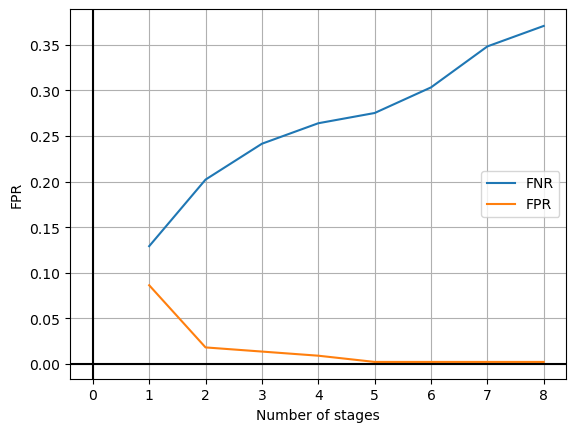

In [8]:
k = np.arange(1,len(classifier)+1,1,dtype=int)
plt.plot(k,np.array(fnr_stage),label = "FNR")
plt.plot(k,np.array(fpr_stage),label = "FPR")

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel('Number of stages')
plt.ylabel('FPR')
plt.legend()
plt.xticks(range(0,len(classifier)+1))
plt.yticks(range(0,1,0.1))



In [9]:
#Number of weak classifiers per stage
features_per_stage 

[8, 12, 25, 24, 20, 14, 9, 2]

In [10]:
#Number of stages of the classifier
stages

8